# Getting Started
To lauch:
`git clone https://github.com/GunsalusPiano/bt_analysis.git`

Then:
```
docker run -v `pwd`:/home/jovyan -p 8888:8888 jupyter/bio-scipy-notebook:latest
```

# BT Analysis
The goal here is to:

-   Extract the full lengths cds
    -   Applying this to both the Crickmore database as well as the Patric data seems to make the most sense going forward - things will just be easier.
-   Check to see if there Patric sequences are full length CDS when compared to
    the Crickmore database. This will be done using blast at the nt/prot level.
    -   If yes then proceed as normal.
    -   If no then try to build out the assembly for each contig.
-   Create a tree showing divergence with the nucleotide sequences of each
    Patric cry protein amongst those registered in the Crickmore db.
-   Analyze the protein domains
    -   Need more details about this analysis

## Get Full Length CDS

### Crickmore
To obtain known cry sequences I used the Crickmore database to grab the accessions for each gene by parsing the [html file](http://www.btnomenclature.info/). I provided all of these to [batch entrez](https://www.ncbi.nlm.nih.gov/sites/batchentrez) and downloaded the protein which were available. For those that were not found in the protein database, I provided those accessions to the nucleotide database and grabbed the CDS. Of all the crickmore sequences only 12 were not found:

The following records can't be retrieved:

- Id=KJ28844:	nuccore: Wrong UID KJ28844
- Id=KJ28845:	nuccore: Wrong UID KJ28845
- Id=KJ28846:	nuccore: Wrong UID KJ28846
- Id=MG674828:	nuccore: Wrong UID MG674828
- Id=MG983752:	nuccore: Wrong UID MG983752
- Id=MG983753:	nuccore: Wrong UID MG983753
- Id=MG983754:	nuccore: Wrong UID MG983754
- Id=MH253686:	nuccore: Wrong UID MH253686
- Id=MH475904:	nuccore: Wrong UID MH475904
- Id=MH475905:	nuccore: Wrong UID MH475905
- Id=MH475906:	nuccore: Wrong UID MH475906
- Id=MH475907:	nuccore: Wrong UID MH475907

Also I manually omitted AL731825 and CP015350 from `cry-accessions.txt` as they were improperly annotated in NCBI.

In [3]:
import os
os.chdir('../crickmore/cry')

In [19]:
## Commented out because I do not need to run them again.

# %%bash
# reformat fasta files to 1 line fasta to allow grep to work easier
# perl ../../../1line-fasta.pl crickmore-cds.fasta > crickmore-cds.1line.fasta
# grep --no-group-separator -A1 -F -f cry-accessions.txt crickmore-cds.1line.fasta  > temp && mv temp crickmore-cds.fasta

Since there were some NCBI entries that were the CDS I translated these into proteins using [transeq](https://www.ebi.ac.uk/seqdb/confluence/display/THD/EMBOSS+Transeq) from the [EMBOSS sotware suite](https://www.ebi.ac.uk/Tools/emboss/).

In [ ]:
## Commented out because I do not need to run them again.

# %%bash
# transeq -clean -sequence crickmore-cds.fasta -outseq crickmore-cds.translated.fasta -frame 1

# Combine them with the existing protein sequences
# cat crickmore-aa.fasta crickmore-cds.translated.fasta > all-cry-aa.fasta

### PATRIC

To start I wanted to see how well blastx matched up with the ToxinScanner results as I will be using blastx (and other flavors) for future analysis and want to make sure that I have the parameters correct. For a simple test I ran it on the d12 sample.

In [4]:
os.chdir('../../patric/d12')

In [ ]:
%%bash

blastx \
-query a1-d12.contigs.fasta \
-db all-cry-aa.fasta \
-out contig-blastx.tsv \
-outfmt '6 qaccver saccver pident length qlen slen mismatch gapopen qstart qend sstart send evalue bitscore' \
-num_threads 4 \
-max_target_seqs 1 \
-culling_limit 1 \
-evalue 0.00005 \
-max_hsps 1

In [7]:
import pandas as pd
import tabulate
df = pd.read_table('contig-blastx.tsv',header=None)
df.columns = 'qaccver saccver pident length qlen slen mismatch gapopen qstart qend sstart send evalue bitscore'.strip().split(' ')
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.precision', 2):
        print(tabulate.tabulate(df, headers='keys', tablefmt='markdown'))

    qaccver                 saccver      pident    length    qlen    slen    mismatch    gapopen    qstart    qend    sstart    send    evalue    bitscore
--  ----------------------  ---------  --------  --------  ------  ------  ----------  ---------  --------  ------  --------  ------  --------  ----------
 0  accn|91061.11.con.0048  Cry6Ba1      30.571       350   17299     395         217          6      8651    9622        43     392  2.25e-32       129
 1  accn|91061.11.con.0049  Cry55Aa3     26.855       283   17477     363         180          8      3098    2307        68     342  2.78e-12        68.2
 2  accn|91061.11.con.0054  Cry6Aa1      28.736       348   15326     475         224          5      6907    7878        37     384  8.96e-37       144
 3  accn|91061.11.con.0055  Cry75Aa3     33.784       222   15041     317         128          8      5681    5064        94     312  3.7e-18         85.1
 4  accn|91061.11.con.0060  Cry4Ba2      76.577       111   12780    1136 

So the results matched the ToxinScanner results for the d12 sample. However, this will need a but more tweaking as some of the alignments (in the `length` field) are very short. To summarize:
* All potential coding sequences from the alignment coordinates (and beyond so that we don't lose miss any potential start/stop codons that are in frame) within the matched contig will be extracted
* Those coding sequences that align to one of our putative toxins will be considered as potential candidates.
* Of these candidates, we will look for domains (?) and/or grab the longest CDS and consider that our toxin.

The initial attempt of this can be seen below in a latter section (coming soon!).

## Alignment
In order to see how divergent our sequences are from the known Cry proteins we will need to construct a multiple-sequence alignment from which we can produce a tree. Since both the Crickmore database as well as the predicted genes from ToxinScanner are not solely full length CDS I had to decide on some cutoffs until we are certain that the data we are working with is perfect. Also, it takes ~8 hours to generate a tree for the 438 sequences that we're working with now - so given time constraints I decided these cutoffs were best for a proof-of-concept. 

A few questions I have about the alignment/tree generation steps are as follows:
- I have read that for some distance based methods the alignment does not have to be perfect and can actually afford many gaps but would like to know for sure.
- There are many methods to estimate distances between sequences. The Crickmore database used UPGMA/neighbor-joining approaches to calculate distances which is good for sequences that are fairly similar. I used a maximum likelihood approach which is tailored to sequences that are very dissimilar. Given that our sequences can be <= 40% identical (to me that seems low) this seemed the best approach to me.
- The Crickmore team used a rooted tree which assumes there is a common ancestor. As far as I know that isn't the case here, so I initially generated an unrooted tree which is better for looking at variability amongst genes as opposed to evolution over time. This is also something I would like more clarity on.

### Filtering Sequences
Given the constraints of the initial analysis, I took the libery of paring down the data into something that I'm more confident in working with as well as something that is quicker. 

From the PATRIC data files I retrieved each of the strain's predicted protein sequences mainly due to the fact that it was a bit of a rabbit hole in trying to find the full lenght CDS based on partial alignments.

These protein sequences were then blasted against the Crickmore datbase. From the blast results I filter the hit for the sequences that:
- have a minimum alignment length of 100aa
- have a minumum length of 1kaa
- have an alignment that covers at least 80% of the sequence of interest
- Have a start and stop codon/aa

All sequences that passed these filtered were then passed on to the alignment algorithm.

In [1]:
os.chdir('..')

a24/                                          BT_Analysis.ipynb  j1/
all-patric-and-crickmore.aa.1k.fasta          d12/               mb11/
all-patric-and-crickmore.aa.1k.mat            font1@             my46/
all-patric-and-crickmore.aa.1k.phy            font2@             plotfile
all-patric-and-crickmore.aa.1k.phy.out        font3@             plotfile.pdf
all-patric-and-crickmore.aa.1k.phy.tree       font4@             s1/
all-patric-and-crickmore.aa.1k.phy.tree.orig  font5@
analysis.sh@                                  font6@


In [3]:
%%bash
for i in a24 j1 my46 mb11 s1 d12
 do
  blastp -query  $i/PATRIC_genome_feature.fasta -db ../crickmore/cry/all-cry-aa.fasta -out $i/PATRIC_genome_feature.blastp.tsv -outfmt '6 qaccver saccver pident length qlen slen mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4 -max_target_seqs 3 -max_hsps 2 -culling_limit 2 -evalue 0.00005

  python3 ../../scripts/filter-blast-results.py -i $i/PATRIC_genome_feature.blastp.tsv  -l 100 -q 80 --qlen 1000 -s $i/PATRIC_genome_feature.fasta -o $i/PATRIC_genome_feature.blastp.filtered.fasta

done

### Alignment

For the alignment algorithm I used clustal omega.

In [ ]:
%%bash

# Filtered the Crickmore database for seqs >= 1kaa
python ../../scripts/filter-seqs.py -s ../crickmore/cry/all-cry-aa.fasta -l 1000 --full > ../crickmore/cry/all-cry-aa.1k.fasta

# Concatenate all the Crickmore and sequences of interest into one file
cat ../crickmore/cry/all-cry-aa.1k.fasta */PATRIC_genome_feature.blastp.filtered.fasta > all-patric-and-crickmore.aa.1k.fasta

# Align using clustal and outputting phylip format
clustalo --outfmt phy --distmat-out all-patric-and-crickmore.aa.1k.mat -v -i all-patric-and-crickmore.aa.1k.fasta -o all-patric-and-crickmore.aa.1k.phy --force --full

### Distance Matrix Calculation
To generate a distance matrix I used [proml](http://evolution.genetics.washington.edu/phylip/doc/proml.html) from the PHYLIP package. Proml is an algorithm that implements maximum liklihood approach to generating a distance matrix. The Crickmore people used [protdist](http://evolution.genetics.washington.edu/phylip/doc/protdist.html) which, as I stated earlier, didn't seem like the right tool for this job. 

proml is an interactive piece of software so I do not have the commands listed here. However, I used the default parameters.

FYI this is a very lengthy algorithm (~8 hours for 438 sequences).

### Tree Drawing

I used [FigTree](http://tree.bio.ed.ac.uk/software/figtree/) to render the tree. There is a PDF [here](./all-patric-and-crickmore.aa.1k.phy.proml.outtree.pdf) for hi-res.

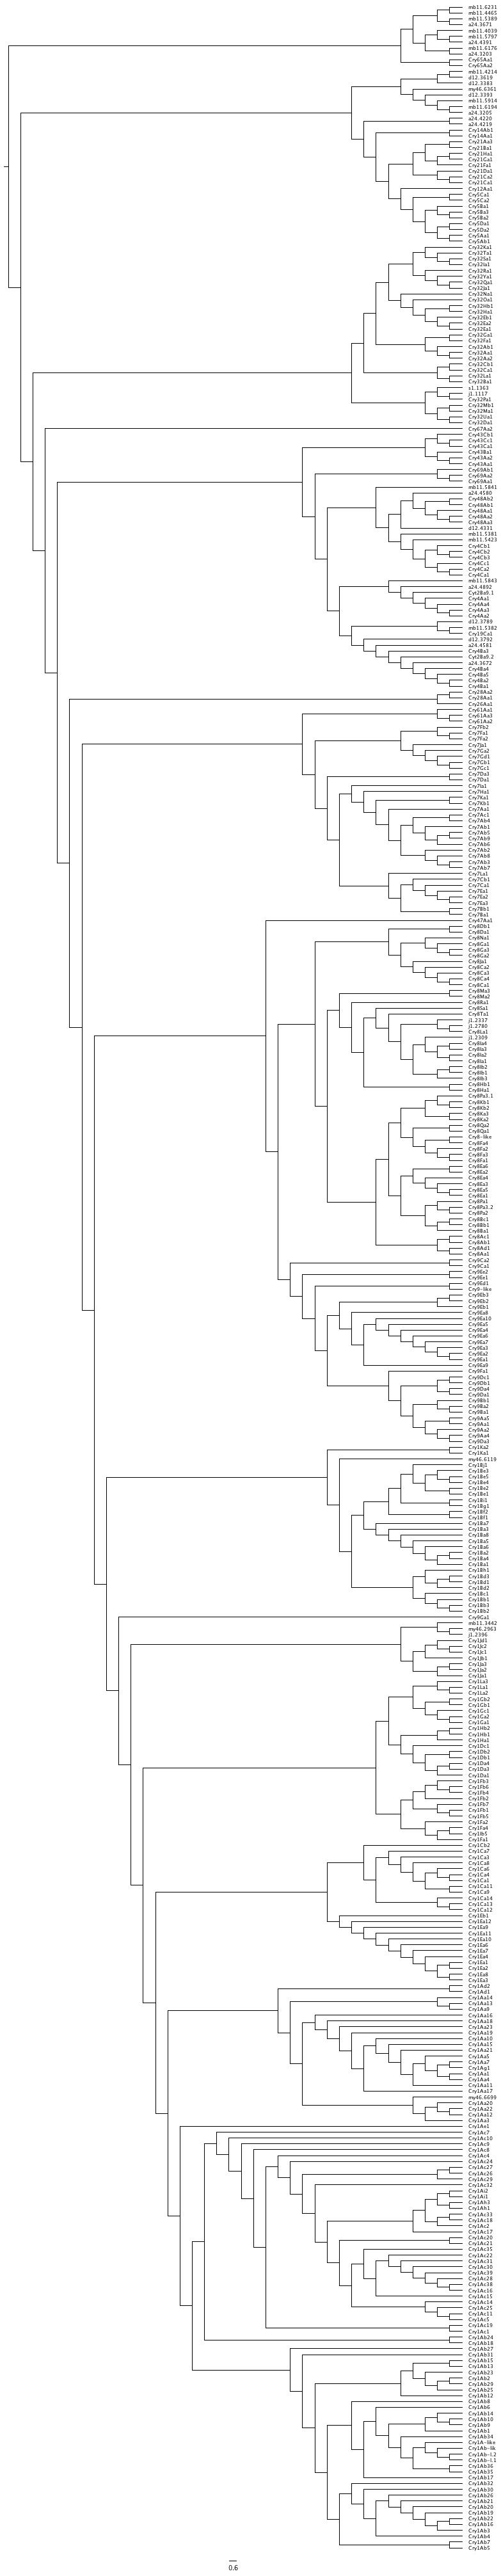

In [14]:
from IPython.display import Image
Image(filename='./all-patric-and-crickmore.aa.1k.phy.proml.outtree.jpg')

A circular tree was generated using [ITOL](https://itol.embl.de/tree/20738162184218261539281062#)

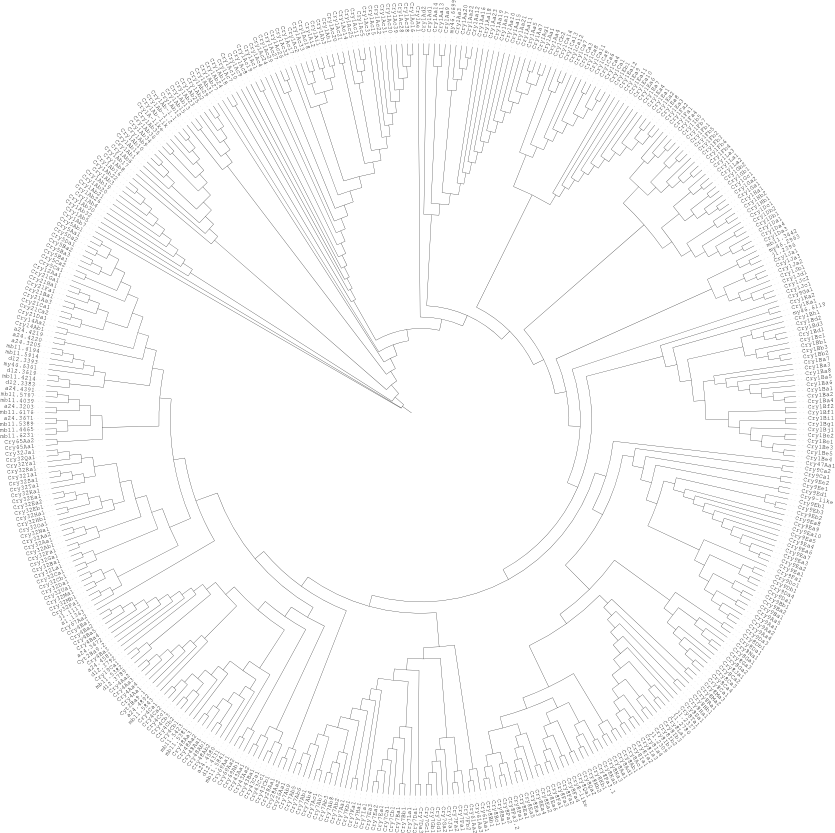

In [3]:
from IPython.display import Image
Image(filename='./all-patric-and-crickmore.aa.1k.phy.proml.outtree.circ.png')

TODO: See if this tree is representative of the blast results from ToxinScanner. I looked at a few sampels from the [spreadsheet](./20180122_Toxin_Scanner.xlsx) and they seem to match up for the most part. a24 in particular seems to have a few misassignments but some further investigation should iron out these wrinkles.

In [6]:
# check how many sequences there are in the tree
!grep -c '>' all-patric-and-crickmore.aa.1k.fasta

402


The script wouldn't render the text because of some QT issues inherent with running Jupyter in a docker instance, so I compiled everything locally and will import the results. Once there is an actualy fix for PyQT I will integrate that into the notebook.

The script can be found here:

In [1]:
!cat ../../scripts/draw-tree.py

from ete3 import Tree, TreeStyle, faces, CircleFace, AttrFace, NodeStyle, TextFace
t = Tree()
# t.populate(30, names_library=range(30))
t = Tree('all-patric-and-crickmore.aa.1k.phy.proml.outtree')


    # vowels = set(["j1.2780"])
    # print("here")
    # if node.name in vowels:
    #
    #    # Note that node style are already initialized with the
    #    # default values
    #
    #    node.style["fgcolor"] = "red"
    #    # node.img_style["color"] = "red"

clades = dict()
hemiptera = [
              "2A", # multiple species
              "3A",
              "11A"
              ]

rhabditida = [
              "5A",
              "5B",
              "12A",
              "13A",
              "14A",
              "21A",
              "55A"
              ]

lepidoptera = [
               "1A",
               "1B",
               "1C",
               "1D",
               "1E",
               "1F",
               "1G",
               "1H",
               "1I",
               "1J",
     

Image from this script can be found at: `./test.pdf`

After getting some feedback it seems like this is close to what we would like to show, so to make things a bit more clear I will:
1) Cluster the Crickmore sequences into representatives of each Rank 1 Cry. I think looking at the distribution of the Crickmore sequences will be very integral into an accurate representation of full-length sequences.
2) All (I think) of the Rank 1s were missed by blast via ToxinScanner. To get something together quickly I'll extract the coordinates from ToxinScanner directly and use those in the analysis.

## Crickmore Database Clustering
I'll start here - clustering these at 45% identity will show us the Rank 1s. I did that already with the 1k-length cutoff and it proved to work with cd-hit.

In [1]:
!cat ./all-patric-and-crickmore.aa.1k.45.cdhit.clstr

>Cluster 0
0	1523aa, >Cry32Ka1... *
1	1461aa, >Cry32Ha1... at 0.0/1309aa/53.11%
2	1427aa, >Cry32Ra1... at 0.0/1295aa/53.81%
3	1371aa, >Cry32Ta1... at 0.0/1325aa/55.65%
4	1350aa, >Cry32Fa1... at 0.0/1317aa/54.88%
5	1313aa, >Cry32Qa1... at 0.0/1319aa/63.13%
6	1305aa, >Cry32Ma1... at 0.0/1338aa/55.78%
7	1302aa, >Cry32Oa1... at 0.0/1308aa/60.67%
8	1296aa, >Cry32Ja1... at 0.0/1353aa/62.57%
9	1287aa, >Cry32Ia1... at 0.0/1325aa/56.79%
10	1284aa, >Cry32Na1... at 0.0/1309aa/59.65%
11	1280aa, >Cry32Da1... at 0.0/1337aa/52.18%
12	1277aa, >Cry32Sa1... at 0.0/783:393aa/46.98%
13	1276aa, >Cry32La1... at 0.0/1344aa/54.93%
14	1270aa, >Cry32Ba1... at 0.0/1313aa/55.59%
15	1268aa, >Cry32Ga1... at 0.0/1312aa/63.24%
16	1259aa, >Cry32Ea1... at 0.0/1286aa/61.87%
17	1254aa, >Cry32Ca1... at 0.0/1320aa/55.66%
18	1242aa, >Cry32Pa1... at 0.0/774:405aa/52.17%
19	1238aa, >Cry32Ua1... at 0.0/775:398aa/56.54%
20	1237aa, >Cry32Aa2... at 0.0/1294aa/58.93%
>Cluster 1
0	1385aa, >Cry5Aa1... *
1	1289aa, >Cry5Ab1... at 0.0/

So, to start let's look at the distribution of Crickmore sequences:

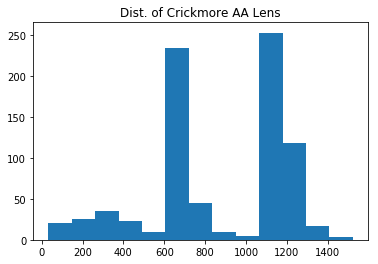

In [9]:
%matplotlib inline
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt

lengths = list()
# the Crickmore aa's
with open('../crickmore/cry/all-cry-aa.fasta','r') as f:
    for record in SeqIO.parse(f, 'fasta'):
        lengths.append(len(record.seq))
    

# plt.hist(lengths, bins=len(set(lengths)))
plt.hist(lengths, bins='auto')
plt.title("Dist. of Crickmore AA Lens")
plt.show()


So it seems like 600 is the cutoff I should use. So let's go with that.

In [11]:
import os
os.chdir('/home/jovyan/data/crickmore/cry')

In [12]:
%%bash
../../../scripts/cdhit/psi-cd-hit/psi-cd-hit.pl \
-i all-cry-aa.fasta \
-o all-cry.aa45.cdhit \
-c 0.45 \
-l 600

BLAST version:
blastp: 2.7.1+
 Package: blast 2.7.1, build Sep 20 2018 02:20:26




Name "main::bl_dir" used only once: possible typo at ../../../scripts/cdhit/psi-cd-hit/psi-cd-hit.pl line 103.
Name "main::bl_dir" used only once: possible typo at ../../../scripts/cdhit/psi-cd-hit/psi-cd-hit.pl line 103.
Name "main::bl_dir" used only once: possible typo at ../../../scripts/cdhit/psi-cd-hit/psi-cd-hit.pl line 103.
Name "main::bl_dir" used only once: possible typo at ../../../scripts/cdhit/psi-cd-hit/psi-cd-hit.pl line 103.
Name "main::bl_dir" used only once: possible typo at ../../../scripts/cdhit/psi-cd-hit/psi-cd-hit.pl line 103.
Name "main::bl_dir" used only once: possible typo at ../../../scripts/cdhit/psi-cd-hit/psi-cd-hit.pl line 103.
Name "main::bl_dir" used only once: possible typo at ../../../scripts/cdhit/psi-cd-hit/psi-cd-hit.pl line 103.
Name "main::bl_dir" used only once: possible typo at ../../../scripts/cdhit/psi-cd-hit/psi-cd-hit.pl line 103.


In [13]:
# Counting the number of representatives per cluster
!grep -c '>' all-cry.aa45.cdhit

61


In [14]:
!cat all-cry.aa45.cdhit.clstr

>Cluster 0
0	1523aa, >Cry32Ka1... *
1	1461aa, >Cry32Ha1... at 0.0/1309aa/53.11%
2	1427aa, >Cry32Ra1... at 0.0/1295aa/53.81%
3	1371aa, >Cry32Ta1... at 0.0/1325aa/55.65%
4	1350aa, >Cry32Fa1... at 0.0/1317aa/54.88%
5	1313aa, >Cry32Qa1... at 0.0/1319aa/63.13%
6	1305aa, >Cry32Ma1... at 0.0/1338aa/55.78%
7	1302aa, >Cry32Oa1... at 0.0/1308aa/60.67%
8	1302aa, >Cry32Mb1... at 0.0/1337aa/57.21%
9	1296aa, >Cry32Ja1... at 0.0/1353aa/62.57%
10	1287aa, >Cry32Ia1... at 0.0/1325aa/56.79%
11	1284aa, >Cry32Na1... at 0.0/1309aa/59.65%
12	1280aa, >Cry32Da1... at 0.0/1337aa/52.18%
13	1277aa, >Cry32Sa1... at 0.0/783:393aa/46.98%
14	1276aa, >Cry32La1... at 0.0/1344aa/54.93%
15	1270aa, >Cry32Ba1... at 0.0/1313aa/55.59%
16	1268aa, >Cry32Ga1... at 0.0/1312aa/63.24%
17	1259aa, >Cry32Ea1... at 0.0/1286aa/61.87%
18	1259aa, >Cry32Ea2... at 0.0/1278aa/61.63%
19	1256aa, >Cry32Hb1... at 0.0/1293aa/62.57%
20	1254aa, >Cry32Ca1... at 0.0/1320aa/55.66%
21	1251aa, >Cry32Cb1... at 0.0/1321aa/56.43%
22	1248aa, >Cry32Eb1... a

In summary, there are 61 Rank 1s with lengths >= 600 AA represented in the Crickmore database. This should be a good start for the analysis.

## PATRIC Cluster Analysis
A way to see which of our genes are considered 'novel' is to look at how they cluster when given a certain identity threshold. To do this I used CD-HIT to cluster based on percent identity between sequences. Since there are different percent identities that segregate the different Cry ranks I will use those to start.

In [4]:
%%bash
for i in 45 78 95
do 
cd-hit \
-i all-patric-and-crickmore.aa.1k.fasta \
-o all-patric-and-crickmore.aa.1k.$i.cdhit \
-T 4 -g 1 -c .$i
done

Program: CD-HIT, V4.7 (+OpenMP), Jul 13 2018, 17:17:44
Command: cd-hit -i all-patric-and-crickmore.aa.1k.fasta -o
         all-patric-and-crickmore.aa.1k.45.cdhit -T 4 -g 1 -c
         .45

Started: Thu Oct 11 03:37:20 2018
                            Output                              
----------------------------------------------------------------
Program: CD-HIT, V4.7 (+OpenMP), Jul 13 2018, 17:17:44
Command: cd-hit -i all-patric-and-crickmore.aa.1k.fasta -o
         all-patric-and-crickmore.aa.1k.78.cdhit -T 4 -g 1 -c
         .78

Started: Thu Oct 11 03:37:20 2018
                            Output                              
----------------------------------------------------------------
total seq: 402
longest and shortest : 1523 and 1044
Total letters: 477041
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 0M
Buffer          : 4 X 10M = 43M
Table           : 2 X 65M = 130M
Miscellaneous   : 0M
Total           : 174M

Table limit with t


Fatal Error:
Too low cluster threshold for the word length.
Increase the threshold or the tolerance, or decrease the word length.
Program halted !!



It seems that 45% is too low an identity threshold for that word length. However, at 95% there are 178 clusters and at 78% there are 119 clusters. I will have to look to see where the others fall into this category.

It seems like psi-cd-hit is the best for clustering proteins at < 50% identity. 

NOTE: I had to compile [cd-hit](https://github.com/weizhongli/cdhit) locally to get it to work as the conda recipe doesn't compile psi-cd-hit.

In [4]:
%%bash
../../scripts/cdhit/psi-cd-hit/psi-cd-hit.pl \
-i all-patric-and-crickmore.aa.1k.78.cdhit \
-o all-patric-and-crickmore.aa.1k.45.cdhit \
-c 0.45

BLAST version:
blastp: 2.7.1+
 Package: blast 2.7.1, build Sep 20 2018 02:20:26




Name "main::bl_dir" used only once: possible typo at ../../scripts/cdhit/psi-cd-hit/psi-cd-hit.pl line 103.
mkdir: cannot create directory ‘all-patric-and-crickmore.aa.1k.78.cdhit-bl’: File exists
mkdir: cannot create directory ‘all-patric-and-crickmore.aa.1k.78.cdhit-blm’: File exists
mkdir: cannot create directory ‘all-patric-and-crickmore.aa.1k.78.cdhit-seq’: File exists
Name "main::bl_dir" used only once: possible typo at ../../scripts/cdhit/psi-cd-hit/psi-cd-hit.pl line 103.
Name "main::bl_dir" used only once: possible typo at ../../scripts/cdhit/psi-cd-hit/psi-cd-hit.pl line 103.
Name "main::bl_dir" used only once: possible typo at ../../scripts/cdhit/psi-cd-hit/psi-cd-hit.pl line 103.


So now that we know that these results do not represent the Rank 1s and are also missing a large portion of the sequences represented in certain clades I will redo this with the clustered Crickmore database as well as extracting the sequences from the ToxinScanner results as opposed to using the blast inferred coordinates.

### Extract ToxinScanner Coordinates

The first step is to get those sequences that were reported from ToxinScanner. I'm not going to worry about whether they're full length CDS for now - the length restrictions are indicative of their completeness based my experience thus far. Copied the Cry data from the ToxinScanner results and put them into their respective directories under the filename `ts.tsv`

In [3]:
import pandas as pd
import tabulate
from Bio import SeqIO
import os
import subprocess
os.chdir('/home/jovyan/data/patric/')

def printDataFrame(strain, df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.precision', 2):
        print("Strain: ",key,"\n",tabulate.tabulate(strains[key], headers='keys', tablefmt='markdown'))
    

class Strain():
    def __init__(self,name):
        self.name = name
        self.base = '/home/jovyan/data/patric/'+name
        self.contigs_file = self.base+'/PATRIC_genome_sequence.fasta'
        self.ts_coords = pd.read_table(self.base+'/ts.tsv')
        self.features_file = self.base+'/PATRIC_genome_feature.fasta'
        
        self.filterCoords()
        self.extractTSSeqs(self.ts_coords_filtered)
        
        
    def filterCoords(self,length=600):
        self.ts_coords_filtered = self.ts_coords[self.ts_coords["Length"] >= 600]
    
    def extractTSSeqs(self, df):
        
        self.ts_seq_file = self.base+'/ts.fasta'
        
        with open(self.ts_seq_file, "w") as f:
            for index,row in df.iterrows():
                seq = row["Protein_ID"].split(".")[0]
                coords = row["Protein_description"].split(" ")
                for record in SeqIO.parse(self.contigs_file, "fasta"):
                    # PATRIC is so stupid. Real name is in the description field. WTF
                    desc = record.description.split("   ")[1].split(".")[0].rstrip()
                    if seq == desc:
                        # I manually inspected some coordinates and ToxinScanner is 
                        # way off. For J1 the TS results are 2480-5809 but the 
                        # PATRIC results, which are an actual CDS, are 2542-5809

                        s = ""
                        start,end = [int(x) for x in coords[1].split('-')]
                        s = record.seq[start-1:end]
#                         if int(coords[0]) < 0:
# #                             s = record.seq[start:end+1]
#                             s = record.seq[start-1:end]
#                             # Need to reverse if its on the negative strand
#                             # will f*ck up alignent if it's not
#                             s = s[::-1]
#                         else:

                        # renaming convention is strain + PATRIC contig number    
#                         print(record.id.split(".")[-1])
                        f.write("".join(['>',self.name+'.'+record.id.split(".")[-1],'\t', \
                                         record.description,'\n',str(s),'\n']))

            
            
# a = Strain("j1")
names = ["j1","a24","d12","mb11","my46","s1"]
strains = dict()

for name in names:
    strain = Strain(name)
    # Protein sequences
    subprocess.call(["getorf","-auto","-sequence",strain.ts_seq_file, \
                     "-outseq",strain.base+"/ts.aa.fasta","-find", "1","-minsize", "600"])
    strain.ts_aa_file = strain.base+"/ts.aa.fasta"
    
    # CDS
    subprocess.call(["getorf","-auto","-sequence",strain.ts_seq_file, \
                 "-outseq",strain.base+"/ts.cds.fasta","-find", "1","-minsize", "600"])
    
        

To explain the code above: I grabbed the coordinates from the TS results, extracted them from the contigs, renamed them to something legible, then translated them into their largest orf.

Now to make sure that the # of orfs found match the number of sequences from toxin scanner.

In [4]:
!grep -c '>' */ts*fasta

a24/ts.aa.fasta:4
a24/ts.fasta:4
d12/ts.aa.fasta:3
d12/ts.fasta:3
j1/ts.aa.fasta:4
j1/ts.fasta:4
mb11/ts.aa.fasta:5
mb11/ts.fasta:5
my46/ts.aa.fasta:2
my46/ts.fasta:2
s1/ts.aa.fasta:4
s1/ts.fasta:4


## Clustered Alignment
Everything checks out! Now to align these with the clustered Crickmore sequences.

In [5]:
%%bash
cat ../crickmore/cry/all-cry.aa45.cdhit */ts.aa.fasta > all-patric-and-crickmore.clustered.aa.600.fasta
clustalo --outfmt phy --distmat-out all-patric-and-crickmore.clustered.aa.600.mat -v -i all-patric-and-crickmore.clustered.aa.600.fasta -o all-patric-and-crickmore.clustered.aa.600.phy --force --full
# clustalo --distmat-out all-patric-and-crickmore.clustered.aa.600.mat -v -i all-patric-and-crickmore.clustered.aa.600.fasta -o all-patric-and-crickmore.clustered.aa.600.aln --force --full


Using 4 threads
Read 83 sequences (type: Protein) from all-patric-and-crickmore.clustered.aa.600.fasta
not more sequences (83) than cluster-size (100), turn off mBed
Calculating pairwise ktuple-distances...
Pairwise distance matrix written to all-patric-and-crickmore.clustered.aa.600.mat
Ktuple-distance calculation progress done. CPU time: 2.29u 0.04s 00:00:02.33 Elapsed: 00:00:01
Guide-tree computation done.
Progressive alignment progress done. CPU time: 78.15u 2.47s 00:01:20.62 Elapsed: 00:00:30
Alignment written to all-patric-and-crickmore.clustered.aa.600.phy


Did the same steps as before. Now let's cluster these and see where they fall!

In [12]:
%%bash
../../scripts/cdhit/psi-cd-hit/psi-cd-hit.pl \
-i all-patric-and-crickmore.clustered.aa.600.fasta \
-o all-patric-and-crickmore.clustered.aa.600.45.fasta \
-c 0.45 

cat all-patric-and-crickmore.clustered.aa.600.45.fasta.clstr

BLAST version:
blastp: 2.7.1+
 Package: blast 2.7.1, build Sep 20 2018 02:20:26


>Cluster 0
0	1523aa, >Cry32Ka1... *
>Cluster 1
0	1385aa, >Cry5Aa1... *
>Cluster 2
0	1369aa, >Cry32Ya1... *
1	628aa, >s1.0059_1... at 7.69e-172/639aa/47.61%
>Cluster 3
0	1344aa, >Cry43Aa1... *
>Cluster 4
0	1328aa, >Cry5Ca1... *
>Cluster 5
0	1302aa, >Cry21Ca1... *
>Cluster 6
0	1265aa, >Cry69Aa2... *
>Cluster 7
0	1261aa, >mb11.0214_1... *
1	1233aa, >Cry4Ca2... at 0.0/1287aa/53.04%
2	1224aa, >mb11.0177_1... at 0.0/1271aa/53.67%
3	1218aa, >d12.0110_1... at 0.0/1307aa/50.57%
4	1186aa, >mb11.0213_1... at 0.0/1244aa/51.09%
5	1167aa, >d12.0065_1... at 0.0/1248aa/46.35%
6	736aa, >a24.0147_1... at 0.0/737aa/88.31%
>Cluster 8
0	1257aa, >Cry12Aa1... *
>Cluster 9
0	1257aa, >Cry1Bh1... *
1	719aa, >my46.0177_1... at 0.0/691aa/60.36%
>Cluster 10
0	1232aa, >Cry8Ta1... *
1	1089aa, >j1.0061_1... at 0.0/1108aa/59.96%
2	1078aa, >j1.0066_1... at 0.0/1129aa/51.85%
>Cluster 11
0	1217aa, >s1.0028_1... *
>Cluster 12
0	1207aa, >Cry7

Name "main::bl_dir" used only once: possible typo at ../../scripts/cdhit/psi-cd-hit/psi-cd-hit.pl line 103.
mkdir: cannot create directory ‘all-patric-and-crickmore.clustered.aa.600.fasta-bl’: File exists
mkdir: cannot create directory ‘all-patric-and-crickmore.clustered.aa.600.fasta-blm’: File exists
mkdir: cannot create directory ‘all-patric-and-crickmore.clustered.aa.600.fasta-seq’: File exists
Name "main::bl_dir" used only once: possible typo at ../../scripts/cdhit/psi-cd-hit/psi-cd-hit.pl line 103.
Name "main::bl_dir" used only once: possible typo at ../../scripts/cdhit/psi-cd-hit/psi-cd-hit.pl line 103.
